In [1]:
import numpy as np
from astropy.table import Table, join, MaskedColumn, vstack, Column
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy
from astropy.time import Time
import pandas as pd
import re
import seaborn as sns
import datetime


from astropy.io import fits

import corner
from numpy import exp
from scipy import integrate
from scipy.integrate import quad
import pdb

from scipy import stats
from scipy.optimize import curve_fit
import scipy.optimize as opt
from multiprocessing import Pool

from scipy.signal import argrelextrema
from scipy.signal import find_peaks

import glob
import lightkurve as lk


from lightkurve.correctors import RegressionCorrector
from lightkurve.correctors import DesignMatrix
from astropy.timeseries import LombScargle

/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_85596/392377372.py:2: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = search[0].download().PDCSAP_FLUX


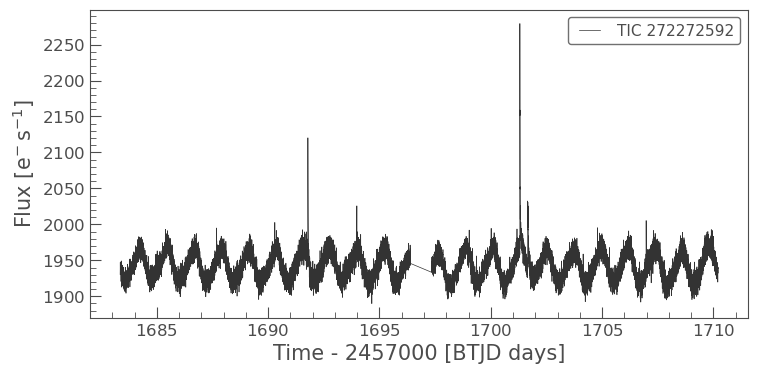

In [2]:
search = lk.search_lightcurve(target='tic272272592', mission='TESS', author='SPOC')
lc = search[0].download().PDCSAP_FLUX
lc=lc[~np.isnan(lc.flux.value)]
lc.plot()
plt.show();

In [3]:
import stella
from tqdm import tqdm_notebook
import os, sys

2023-07-31 17:56:13.573649: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
OUT_DIR='/Users/Tobin/Dropbox/Stellar_Flares_Project/Getting Started/Results/'

In [5]:
cnn = stella.ConvNN(output_dir=OUT_DIR)

Can only use stella.ConvNN.predict().


In [6]:
from stella.download_nn_set import DownloadSets

In [7]:
ds = DownloadSets()
ds.download_models()

Models have already been downloaded to ~/.stella/models


In [8]:
MODELS=ds.models

In [9]:
cnn.predict(modelname='/Users/Tobin/.stella/models/hlsp_stella_tess_ensemblemodel_s000_tess_v0.1.0_cnn.h5',
            times=lc.time.value,
            fluxes=lc.flux.value,
            errs=lc.flux_err.value)
single_pred = cnn.predictions[0]

2023-07-31 17:56:21.304231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


In [10]:
len(lc)

18424

In [11]:
len(cnn.predictions[0])

18424

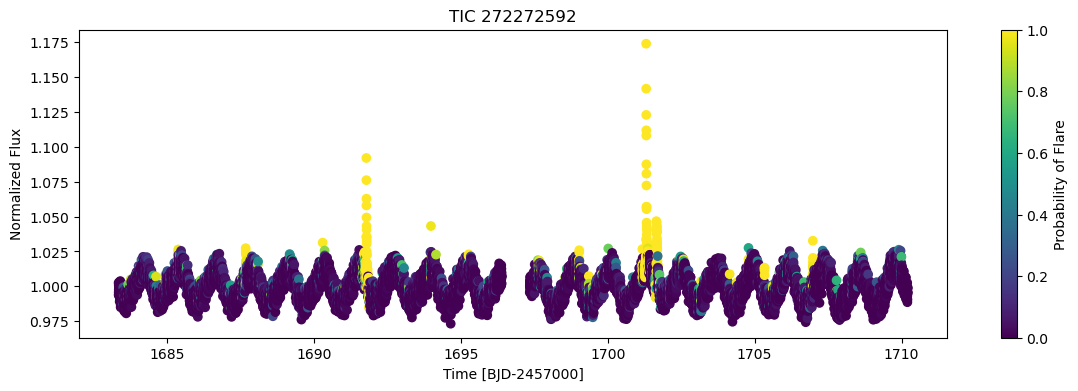

In [12]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=single_pred, vmin=0, vmax=1)
plt.colorbar(label='Probability of Flare')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
plt.title('TIC {}'.format(lc.targetid))
plt.show()

In [13]:
preds = np.zeros((len(MODELS),len(cnn.predictions[0])))

for i, model in enumerate(MODELS):
    cnn.predict(modelname=model,
                times=lc.time.value,
                fluxes=lc.flux.value,
                errs=lc.flux_err.value)
    preds[i] = cnn.predictions[0]

avg_pred = np.nanmedian(preds, axis=0)


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


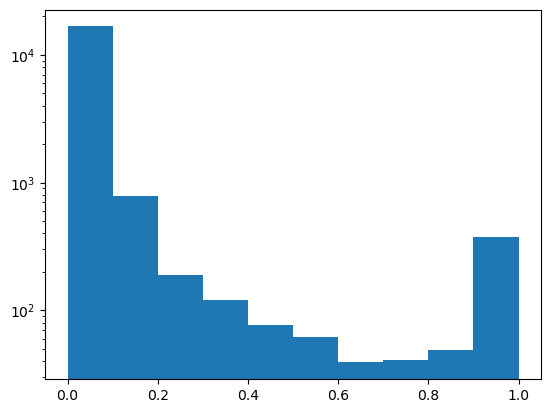

In [14]:
plt.hist(avg_pred)
plt.yscale('log')
plt.show()

In [15]:
ff = stella.FitFlares(id=[lc.targetid],
                      time=[lc.time.value],
                      flux=[lc.flux.value],
                      flux_err=[lc.flux_err.value],
                      predictions=[avg_pred])

ff.identify_flare_peaks(threshold=0.5)

ff.flare_table

Finding & Fitting Flares:   0%|                           | 0/1 [00:00<?, ?it/s]/Users/Tobin/Dropbox/Stellar_Flares_Project/Getting Started/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|███████████████████| 1/1 [00:00<00:00,  3.20it/s]


Target_ID,tpeak,amp,ed_s,rise,fall,prob
float64,float64,float64,float64,float64,float64,float64
272272592.0,1684.9521803763873,1.0157092847036178,16.751059019047904,0.0036365685495423268,0.01,0.5671409666538239
272272592.0,1704.3884040443288,1.0092310833412417,1.6944552544537417,0.0001,0.001270415950611141,0.6443952918052673


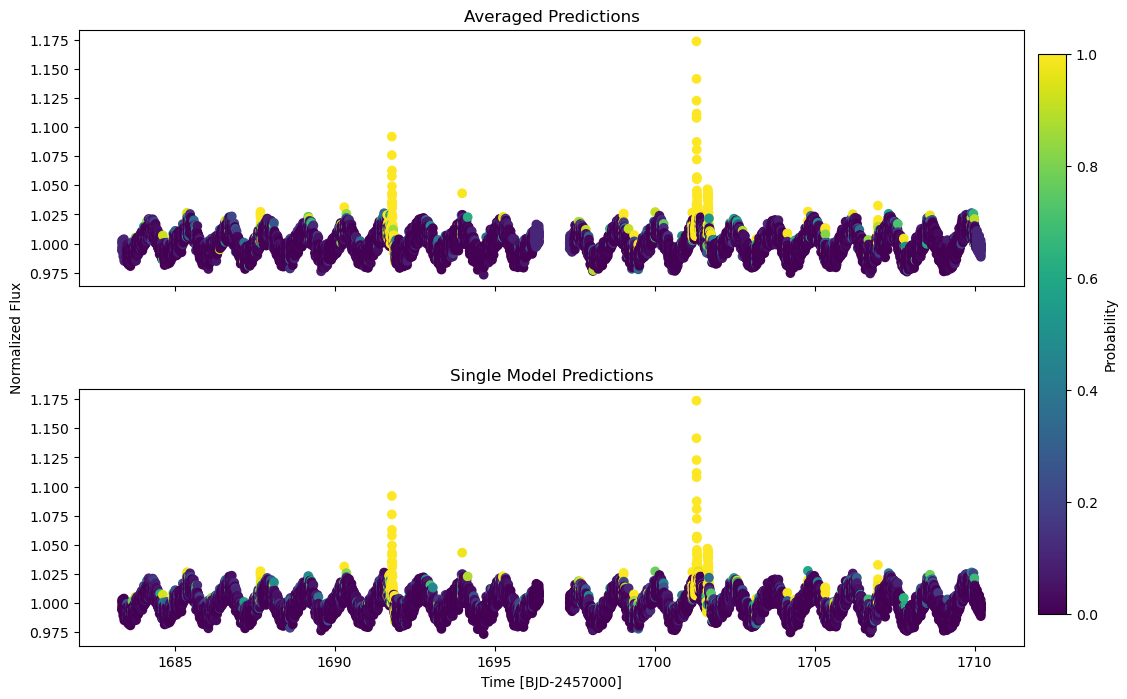

In [16]:
fig, (ax1, ax2) = plt.subplots(figsize=(14,8), nrows=2,
                               sharex=True, sharey=True)
im = ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1)
ax2.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=single_pred, vmin=0, vmax=1)
ax2.set_xlabel('Time [BJD-2457000]')
ax2.set_ylabel('Normalized Flux', y=1.2)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Probability')


ax1.set_title('Averaged Predictions')
ax2.set_title('Single Model Predictions')

plt.subplots_adjust(hspace=0.4)
plt.show()

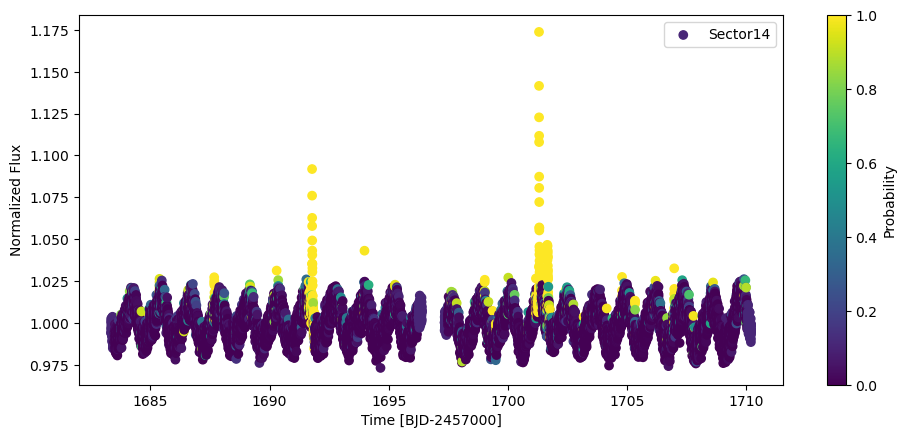

In [17]:
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1, label=('Sector'+str(lc.sector)))
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
plt.colorbar(label='Probability')
plt.legend()
plt.subplots_adjust(right=1.5)
plt.show()

/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_85596/555319934.py:11: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = search[i].download().PDCSAP_FLUX


Can only use stella.ConvNN.predict().


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


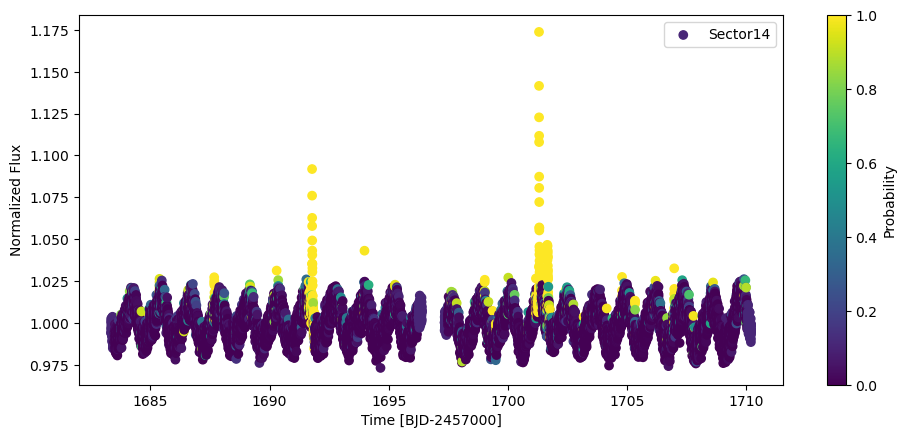

/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_85596/555319934.py:11: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = search[i].download().PDCSAP_FLUX


Can only use stella.ConvNN.predict().


  0%|                                                     | 0/1 [00:00<?, ?it/s]

476/476 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

476/476 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

476/476 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

476/476 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

476/476 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

476/476 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

476/476 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

476/476 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

476/476 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

476/476 [==============================] - 1s 2ms/step


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


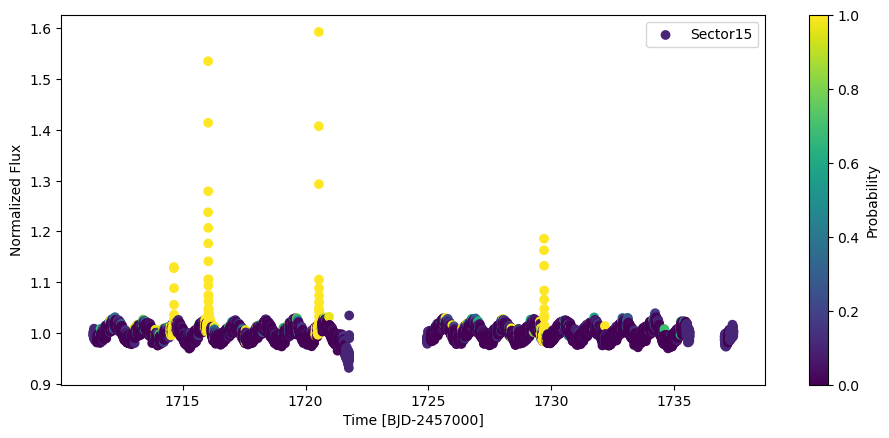

/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_85596/555319934.py:11: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = search[i].download().PDCSAP_FLUX


Can only use stella.ConvNN.predict().


  0%|                                                     | 0/1 [00:00<?, ?it/s]

573/573 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

573/573 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

573/573 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

573/573 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

573/573 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

573/573 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

573/573 [==============================] - 2s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

573/573 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

573/573 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

573/573 [==============================] - 1s 2ms/step


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


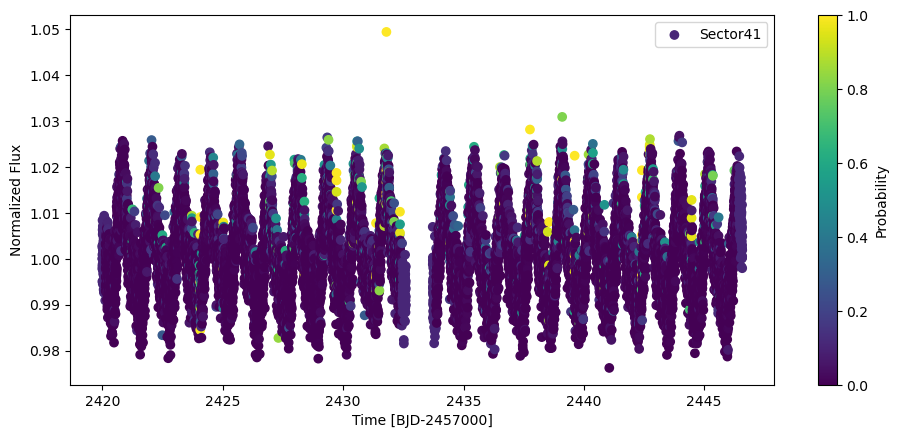

/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_85596/555319934.py:11: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = search[i].download().PDCSAP_FLUX


Can only use stella.ConvNN.predict().


  0%|                                                     | 0/1 [00:00<?, ?it/s]

560/560 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

560/560 [==============================] - 2s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

560/560 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

560/560 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

560/560 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

560/560 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

560/560 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

560/560 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

560/560 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

560/560 [==============================] - 1s 2ms/step


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


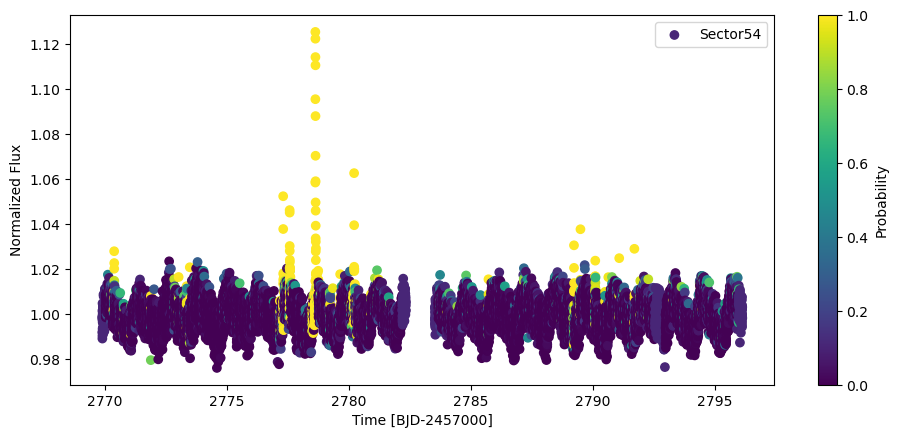

/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_85596/555319934.py:11: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = search[i].download().PDCSAP_FLUX


Can only use stella.ConvNN.predict().


  0%|                                                     | 0/1 [00:00<?, ?it/s]

591/591 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

591/591 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

591/591 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

591/591 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

591/591 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

591/591 [==============================] - 2s 3ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

591/591 [==============================] - 2s 3ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

591/591 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

591/591 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

591/591 [==============================] - 2s 3ms/step


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.04s/it]


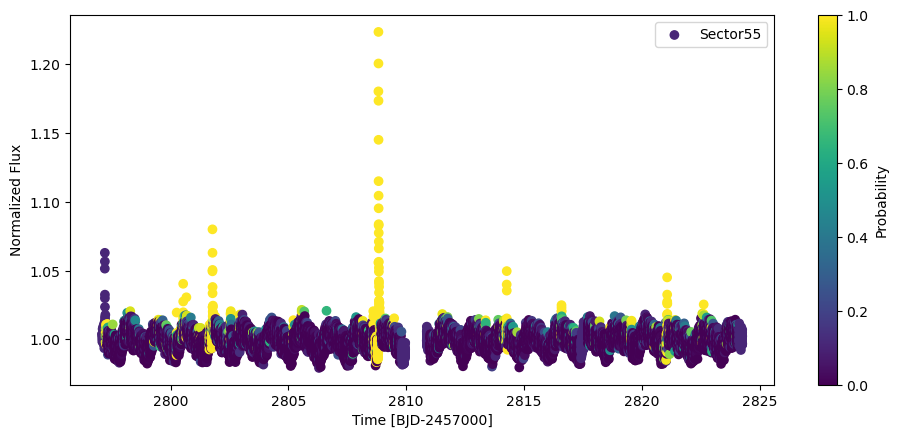

In [18]:
#Iterating through each sector:

search = lk.search_lightcurve(target='tic272272592', mission='TESS', author='SPOC')

times=[]
predictions=[]
av_preds=[]

for i in range(len(search)):
    search = lk.search_lightcurve(target='tic272272592', mission='TESS', author='SPOC')
    lc = search[i].download().PDCSAP_FLUX
    lc=lc[~np.isnan(lc.flux.value)]
#    lc.plot();

    cnn = stella.ConvNN(output_dir=OUT_DIR)
    
    preds = np.zeros((len(MODELS),len(lc)))

    for j, model in enumerate(MODELS):
        cnn.predict(modelname=model,
                    times=lc.time.value,
                    fluxes=lc.flux.value,
                    errs=lc.flux_err.value)
        preds[j] = cnn.predictions[0]

    avg_pred = np.nanmedian(preds, axis=0)
    
    fig=plt.figure()
    plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1, label=('Sector'+str(lc.sector)))
    plt.xlabel('Time [BJD-2457000]')
    plt.ylabel('Normalized Flux')
    plt.colorbar(label='Probability')
    plt.legend()
    plt.subplots_adjust(right=1.5)
    plt.show()
    plt.close(fig)
    
    times.append(np.array(cnn.predict_time[0]))
    predictions.append(np.array(cnn.predict_flux[0]))
    av_preds.append(avg_pred)

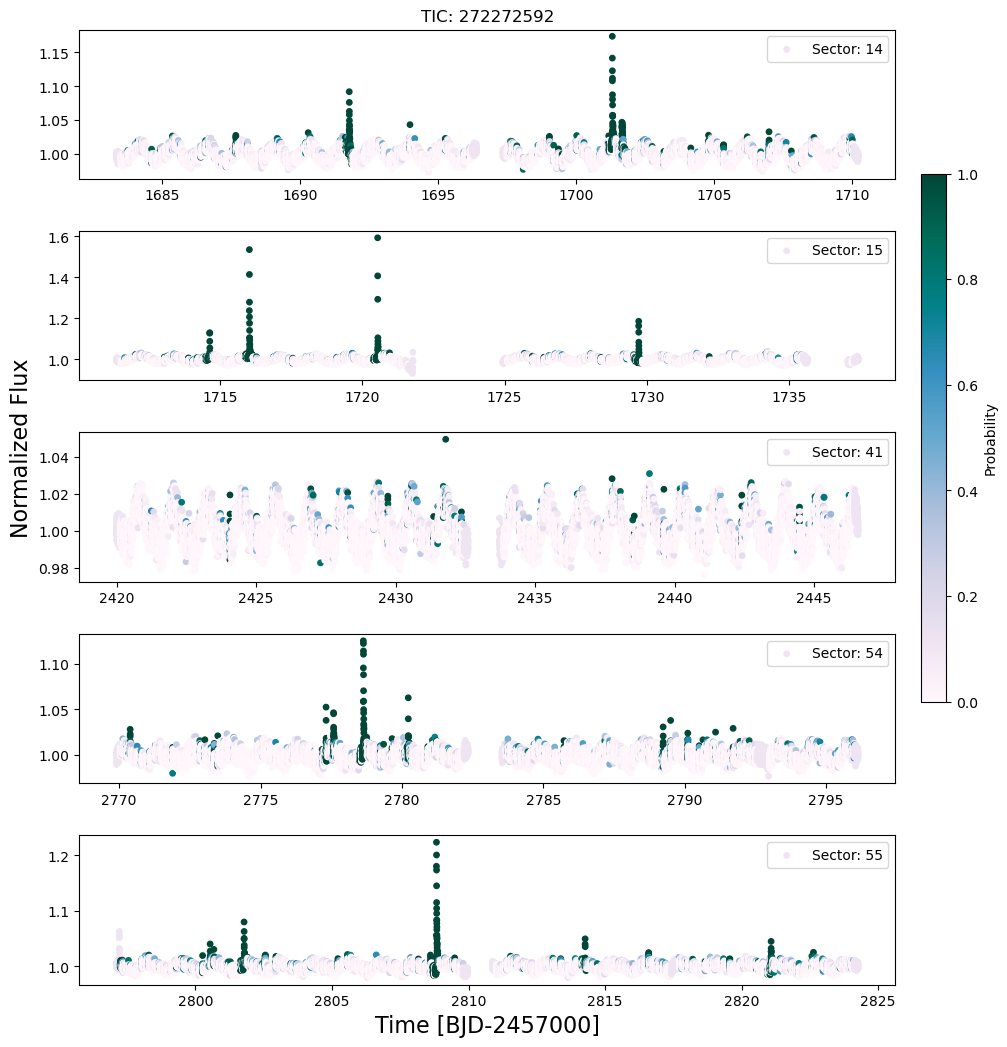

In [19]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5,
                               sharex=False, sharey=False)

ax1=plt.subplot(5,1,1)
im = ax1.scatter(times[0], predictions[0], s=15,
            c=av_preds[0], cmap='PuBuGn', vmin=0, vmax=1, label='Sector: 14')
ax1.set_title('TIC: 272272592')
ax1.legend()

ax2=plt.subplot(5,1,2)
ax2.scatter(times[1], predictions[1], s=15,
            c=av_preds[1], cmap='PuBuGn', vmin=0, vmax=1, label='Sector: 15')
ax2.legend()

ax3=plt.subplot(5,1,3)
ax3.scatter(times[2], predictions[2], s=15,
            c=av_preds[2], cmap='PuBuGn', vmin=0, vmax=1, label='Sector: 41')
ax3.set_ylabel('Normalized Flux', y=.9, fontsize=16)
ax3.legend()

ax4=plt.subplot(5,1,4)
ax4.scatter(times[3], predictions[3], s=15,
            c=av_preds[3], cmap='PuBuGn', vmin=0, vmax=1, label='Sector: 54')
ax4.legend()

ax5=plt.subplot(5,1,5)
ax5.scatter(times[4], predictions[4], s=15,
            c=av_preds[4], cmap='PuBuGn', vmin=0, vmax=1, label='Sector: 55')
ax5.set_xlabel('Time [BJD-2457000]', fontsize=16)
ax5.legend()



plt.subplots_adjust(right=1.4, top=2.1)
cbar_ax = fig.add_axes([1.44, .7, 0.04, 1.1])
fig.colorbar(im, cax=cbar_ax, label='Probability')


plt.subplots_adjust(hspace=0.35)
plt.show()

In [20]:
Choose different color scheme

Make TIC capitalized

Make Wider

Mark Individual flares

Same points smaller

Have my transition of .3 shown destincly in the color_bar


SyntaxError: invalid syntax (1835456650.py, line 1)

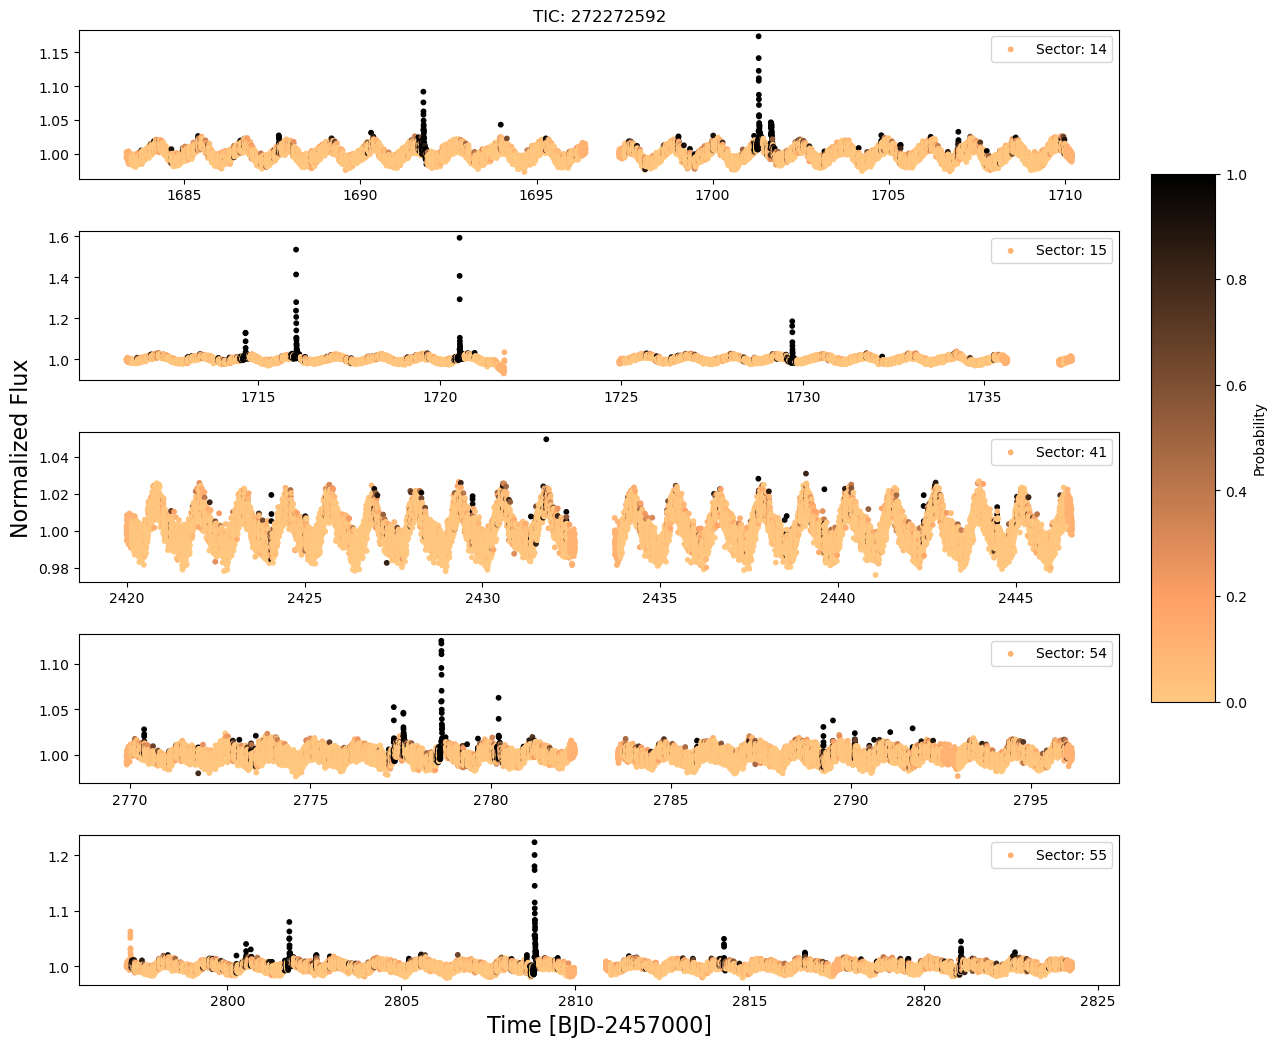

In [28]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5,
                               sharex=False, sharey=False)

ax1=plt.subplot(5,1,1)
im = ax1.scatter(times[0], predictions[0], s=10,
            c=av_preds[0], cmap='copper_r', vmin=0, vmax=1, label='Sector: 14')
ax1.set_title('TIC: 272272592')
ax1.legend()

ax2=plt.subplot(5,1,2)
ax2.scatter(times[1], predictions[1], s=10,
            c=av_preds[1], cmap='copper_r', vmin=0, vmax=1, label='Sector: 15')
ax2.legend()

ax3=plt.subplot(5,1,3)
ax3.scatter(times[2], predictions[2], s=10,
            c=av_preds[2], cmap='copper_r', vmin=0, vmax=1, label='Sector: 41')
ax3.set_ylabel('Normalized Flux', y=.9, fontsize=16)
ax3.legend()

ax4=plt.subplot(5,1,4)
ax4.scatter(times[3], predictions[3], s=10,
            c=av_preds[3], cmap='copper_r', vmin=0, vmax=1, label='Sector: 54')
ax4.legend()

ax5=plt.subplot(5,1,5)
ax5.scatter(times[4], predictions[4], s=10,
            c=av_preds[4], cmap='copper_r', vmin=0, vmax=1, label='Sector: 55')
ax5.set_xlabel('Time [BJD-2457000]', fontsize=16)
ax5.legend()



plt.subplots_adjust(right=1.75, top=2.1)
cbar_ax = fig.add_axes([1.8, .7, 0.1, 1.1])
fig.colorbar(im, cax=cbar_ax, label='Probability', )


plt.subplots_adjust(hspace=0.35)
plt.show()

In [20]:
ff = stella.FitFlares(id=[lc.targetid],
                      time=[lc.time.value],
                      flux=[lc.flux.value],
                      flux_err=[lc.flux_err.value],
                      predictions=[cnn.predictions[0]])

ff.identify_flare_peaks(threshold=0.5)

ff.flare_table

Finding & Fitting Flares:   0%|                           | 0/1 [00:00<?, ?it/s]/Users/Tobin/Dropbox/Stellar_Flares_Project/Getting Started/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|███████████████████| 1/1 [00:00<00:00,  2.29it/s]


Target_ID,tpeak,amp,ed_s,rise,fall,prob
float64,float64,float64,float64,float64,float64,float64
272272592.0,2801.282350470585,1.0181302734861681,15.70367898494875,0.0015367533880401563,0.01,0.7938235998153687


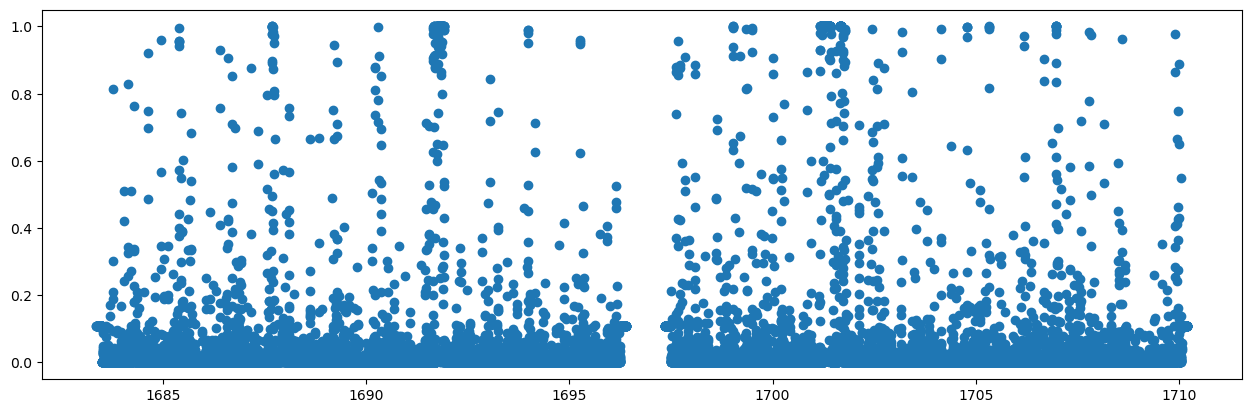

In [21]:
plt.scatter(times[0], av_preds[0])
plt.subplots_adjust(right=2.0)
plt.show()

In [22]:
from scipy.signal import find_peaks, peak_widths, argrelextrema

peak_ind, peak_info=find_peaks(av_preds[0], height=.95)

peak_info


{'peak_heights': array([0.9583616 , 0.99681923, 0.95302951, 1.        , 0.97616243,
        0.99779427, 0.95218992, 0.97057375, 0.99696904, 0.99838632,
        0.99205714, 0.99999997, 0.99969259, 0.99999529, 0.99989536,
        0.99999988, 0.9975403 , 0.9999924 , 0.99561673, 0.99996296,
        0.99999073, 1.        , 0.98921067, 0.9944019 , 0.99975246,
        0.99999967, 0.99999562, 0.99999756, 0.99942651, 0.99995151,
        0.99998766, 0.99999398, 0.99999961, 0.9896307 , 0.99999979,
        0.98947692, 0.99009159, 0.96008298, 0.95731273, 0.99998382,
        0.99374422, 0.99609357, 0.98842558, 1.        , 1.        ,
        0.99990255, 1.        , 0.99999893, 1.        , 0.99982426,
        1.        , 1.        , 1.        , 0.99999514, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.99999881, 0.99999845, 1.        , 1.        ,
        0.99999881, 0.99862599, 0.99698293, 1.        , 1.        ,
        0.97795835, 1.        , 

In [23]:
times[0][peak_ind]

array([1684.95079147, 1685.38412927, 1685.38690707, 1687.67998538,
       1687.68831879, 1687.69109659, 1687.73415256, 1687.73693037,
       1690.29945419, 1691.64252169, 1691.6494662 , 1691.67307752,
       1691.68696653, 1691.69668884, 1691.72724466, 1691.74113367,
       1691.74668928, 1691.74946708, 1691.75780049, 1691.76474499,
       1691.76752279, 1691.80224532, 1691.83002334, 1691.83419005,
       1691.83696785, 1691.84252345, 1691.84807906, 1691.85085686,
       1691.85919027, 1691.86891257, 1691.87446818, 1691.88835719,
       1691.89113499, 1691.9022462 , 1691.905024  , 1693.98143123,
       1693.98420903, 1695.2661656 , 1697.67312795, 1699.02868442,
       1699.35646228, 1699.49118453, 1699.49396231, 1701.17729548,
       1701.20090658, 1701.20646213, 1701.2106288 , 1701.21757324,
       1701.22173991, 1701.22868435, 1701.27173989, 1701.28146211,
       1701.28979544, 1701.29812877, 1701.30090654, 1701.32451764,
       1701.34812875, 1701.35090652, 1701.3536843 , 1701.35923

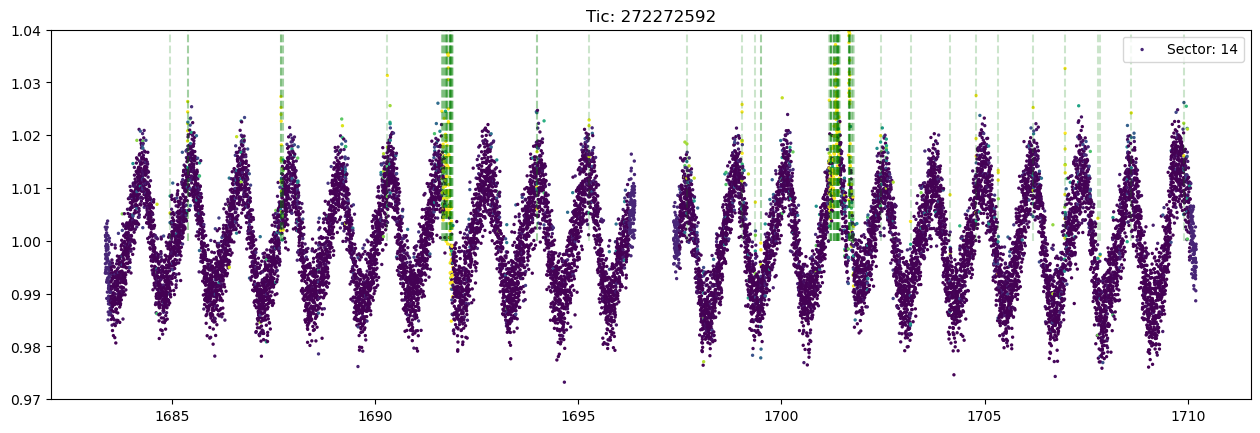

In [24]:
ax1=plt.subplot(1,1,1)
im = ax1.scatter(times[0], predictions[0],
            c=av_preds[0], vmin=0, vmax=1, label='Sector: 14', s=2)
ax1.vlines(x=times[0][peak_ind], ymin=1, ymax=1.1, linestyle='--', color='green', alpha=.2)
ax1.set_title('Tic: 272272592')
ax1.legend()
ax1.set_ylim(0.97, 1.04)

plt.subplots_adjust(right=2.0)
plt.show()

In [25]:
# Lump togther any adjacent data points and call them flares
# Lump together flares that occur within a few hours 

# Leave a little buffer (add on .05 days on each side of the flare) and mask them out 

# Mask the background 

# Need a Guassian Process 

# Fit the background continum around each flare

In [26]:
# Start flare with point above threshold
# Within X data points, if there is a data point above threshold add to flare and resart timer

In [27]:
# OR find flare, fit with model 

In [28]:
# Do LSP training the GP based on the LSP frequency 

In [29]:
# Most Helpful: 
    # scritify this process with new 

In [110]:
x = lc.time.value
y = lc.flux.value

yerr= lc.flux_err.value

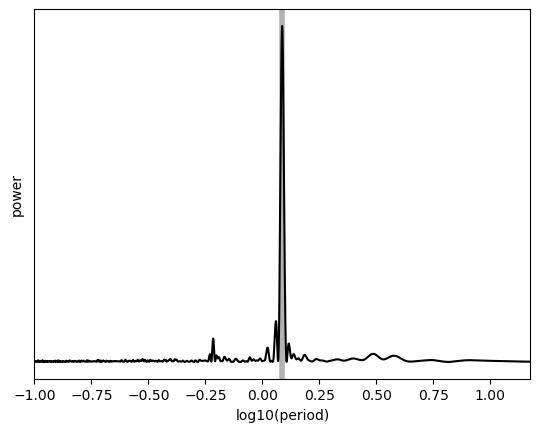

In [31]:
#Looking at GP


import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=.1, max_period=15.0,
    samples_per_peak=50)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(peak["period"]), color="k", lw=4, alpha=0.3)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power")
plt.show();

In [109]:
import celerite2
from celerite2 import terms

# Quasi-periodic term
term1 = terms.SHOTerm(sigma=1.0, rho=1.0, tau=10.0)

# Non-periodic component
term2 = terms.SHOTerm(sigma=1.0, rho=5.0, Q=0.25)
kernel = term1 + term2

# Setup the GP
gp = celerite2.GaussianProcess(kernel, mean=0.0)
gp.compute(x, yerr=yerr)

print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -9345227.43910526


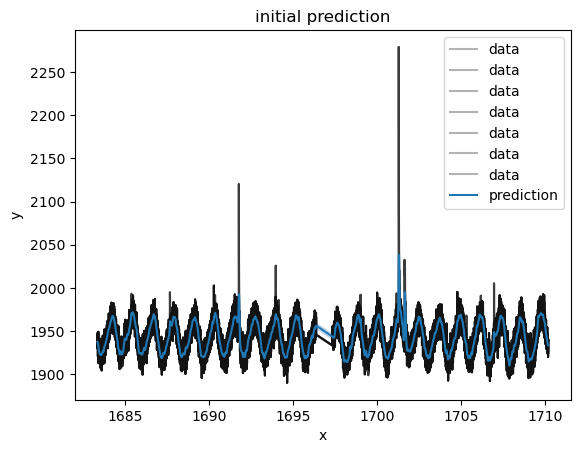

In [138]:
def plot_prediction(gp):
    plt.plot(x, y, "k", lw=1.5, alpha=0.3, label="data")
    #plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label="truth")

    if gp:
        mu, variance = gp.predict(y, t=x, return_var=True)
        sigma = np.sqrt(variance)
        plt.plot(x, mu, label="prediction")
        plt.fill_between(x, mu - sigma, mu + sigma, color="C0", alpha=0.2)

    plt.xlabel("x")
    plt.ylabel("y")
    #plt.xlim(0, 10)
    #plt.ylim(-2.5, 2.5)
    plt.legend()


plt.title("initial prediction")
plot_prediction(gp)
plt.show()

In [34]:
from scipy.optimize import minimize


def set_params(params, gp):
    gp.mean = params[0]
    theta = np.exp(params[1:])
    gp.kernel = terms.SHOTerm(
        sigma=theta[0], rho=theta[1], tau=theta[2]
    ) + terms.SHOTerm(sigma=theta[3], rho=theta[4], Q=0.25)
    gp.compute(x, diag=yerr**2 + theta[5], quiet=True)
    return gp


def neg_log_like(params, gp):
    gp = set_params(params, gp)
    return -gp.log_likelihood(y)


initial_params = [0.0, 0.0, 0.0, np.log(10.0), 0.0, np.log(5.0), np.log(0.01)]
soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(gp,))
opt_gp = set_params(soln.x, gp)
soln

      fun: 70784.07605081685
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.02764864, -0.35215635, -0.30267984,  0.12951205,  0.21827873,
       -0.89494279,  0.        ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 232
      nit: 22
     njev: 29
   status: 0
  success: True
        x: array([ 3.43537554e-03,  1.31974641e-01,  2.28259997e-01,  2.24753150e+00,
        6.67319580e+00,  1.00698916e+00, -4.60517019e+00])

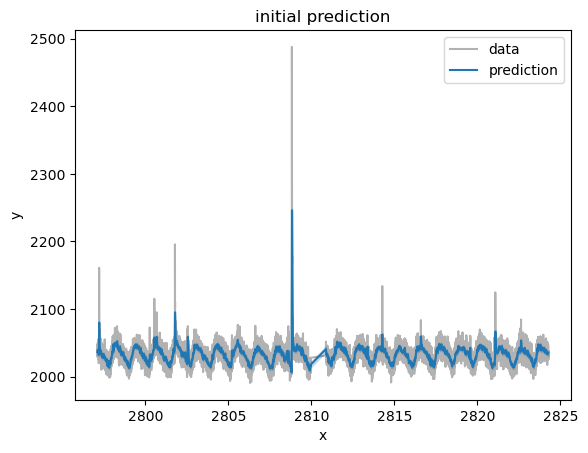

In [35]:
plt.title("initial prediction")
plot_prediction(opt_gp)
plt.show()

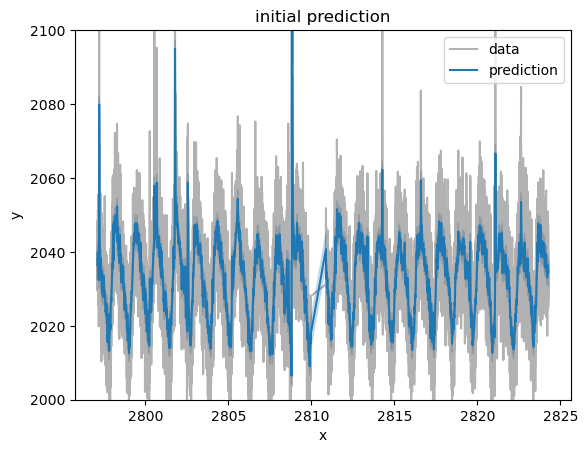

In [36]:
plt.title("initial prediction")
plot_prediction(opt_gp)
plt.ylim(2000, 2100)
plt.show()

In [94]:
flare_list=[]
flare_ind_used=[]
flare_flux_used=[]

start=0
flare=[]
flare_ind=[]
flare_flux=[]
for i in range(len(times[0])):
    count=i-start
    if av_preds[0][i] > .3 :
        # starting_flare
        start=i
        flare.append(times[0][i])
        flare_flux.append(predictions[0][i])
        flare_ind.append(i)
        if count > 20:
            flare_list.append(flare)
            flare_ind_used.append(np.array(flare_ind))
            flare_flux_used.append(flare_flux)
            flare=[]
            flare_ind=[]
            flare_flux=[]
    else:
        continue
        

In [ ]:
# Have probs avar boolean, cluster together yeses 

In [ ]:
# look at previous step

In [ ]:
flare_ind_used=[]
flare_starts=[]
flare_stops=[]

dt=0
for i in range(len(times[0])):
    count=i-start
    if av_preds[0][i] > .3 :
        # starting_flare
        t1=i
        t2=i

In [95]:
robust_flare_ind=[]
for i in range(len(flare_list)):
    if len(flare_list[i]) > 5:
        robust_flare_ind.append(i)
        
robust_flare_time=np.array(flare_list)[np.array(robust_flare_ind)]
robust_flare_time

robust_flare_flux=np.array(flare_flux_used)[np.array(robust_flare_ind)]
robust_flare_flux

robust_flare_indices=np.array(flare_ind_used)[np.array(robust_flare_ind)]
robust_flare_indices

/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_64209/256056012.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  robust_flare_time=np.array(flare_list)[np.array(robust_flare_ind)]
/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_64209/256056012.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  robust_flare_flux=np.array(flare_flux_used)[np.array(robust_flare_ind)]
/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_64209/256056012.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (whic

array([array([1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1474]),
       array([1636, 1639, 1640, 1641, 1642, 1985]),
       array([3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3089,
              3090, 3091, 3092, 3093, 3094, 3107, 3121, 3122, 3123, 3124, 3126,
              3127, 3264])                                                     ,
       array([3362, 3363, 3364, 3365, 3367, 3718]),
       array([4177, 4178, 4180, 4181, 4182, 4303]),
       array([4955, 4956, 4957, 4958, 4959, 4960, 5059]),
       array([5876, 5878, 5879, 5880, 5881, 5882, 5883, 5896, 5897, 5898, 5899,
              5900, 5904, 5905, 5906, 5907, 5908, 5909, 5910, 5911, 5912, 5913,
              5914, 5915, 5916, 5917, 5918, 5936, 5937, 5938, 5939, 5940, 5941,
              5942, 5943, 5944, 5945, 5946, 5947, 5948, 5949, 5950, 5951, 5952,
              5953, 5954, 5955, 5956, 5957, 5958, 5959, 5960, 5961, 5962, 5963,
              5964, 5965, 5966, 5967, 5968, 5969, 5970, 5971, 5972, 5973, 5

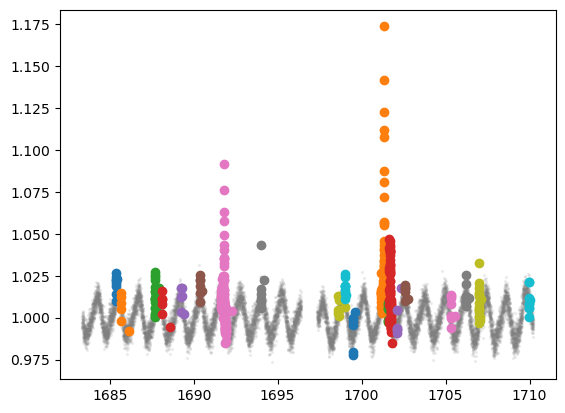

In [96]:
plt.scatter(times[0], predictions[0], color='gray', alpha=.1, label='Sector: 14', s=2)

for i in range(len(robust_flare_time)):
    plt.scatter(robust_flare_time[i], robust_flare_flux[i])
    
plt.show()

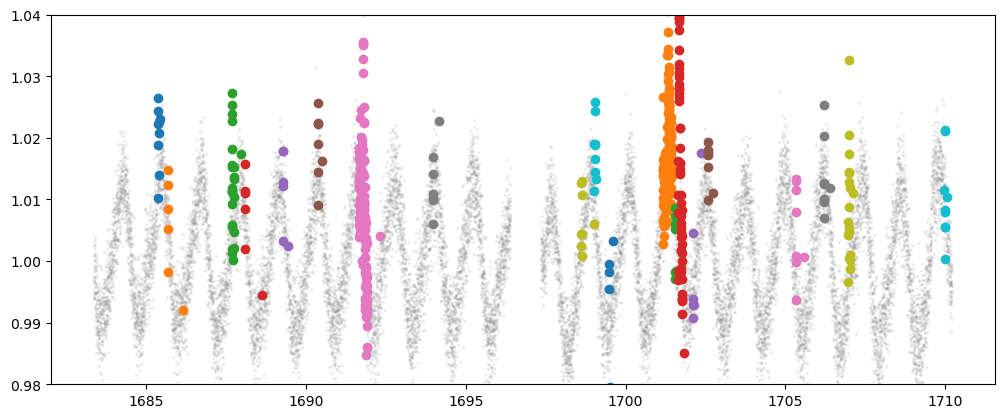

In [97]:
plt.scatter(times[0], predictions[0], color='gray', alpha=.1, label='Sector: 14', s=2)

for i in range(len(robust_flare_time)):
    plt.scatter(robust_flare_time[i], robust_flare_flux[i])

plt.ylim(0.98, 1.04)
plt.subplots_adjust(right=1.6)
plt.show()

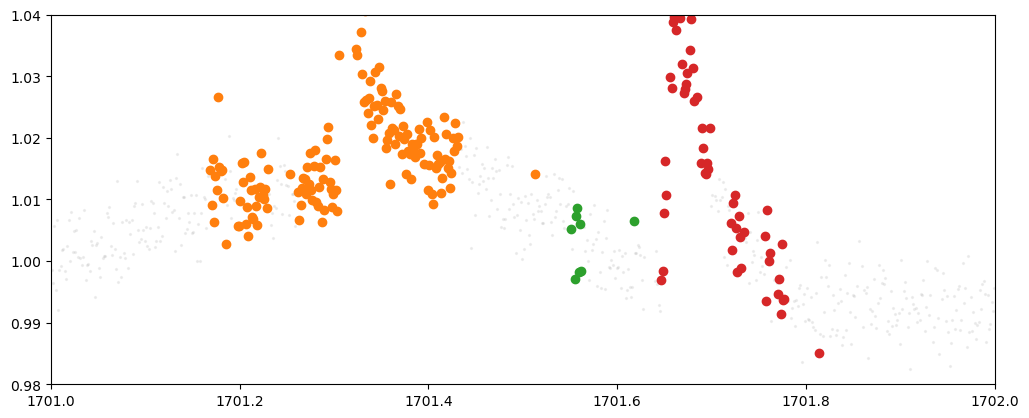

In [98]:
plt.scatter(times[0], predictions[0], color='gray', alpha=.1, label='Sector: 14', s=2)

for i in range(len(robust_flare_time)):
    plt.scatter(robust_flare_time[i], robust_flare_flux[i])

plt.ylim(0.98, 1.04)
plt.xlim(1701, 1702)
plt.subplots_adjust(right=1.6)
plt.show()

In [99]:
robust_flare_indices

array([array([1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1474]),
       array([1636, 1639, 1640, 1641, 1642, 1985]),
       array([3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3089,
              3090, 3091, 3092, 3093, 3094, 3107, 3121, 3122, 3123, 3124, 3126,
              3127, 3264])                                                     ,
       array([3362, 3363, 3364, 3365, 3367, 3718]),
       array([4177, 4178, 4180, 4181, 4182, 4303]),
       array([4955, 4956, 4957, 4958, 4959, 4960, 5059]),
       array([5876, 5878, 5879, 5880, 5881, 5882, 5883, 5896, 5897, 5898, 5899,
              5900, 5904, 5905, 5906, 5907, 5908, 5909, 5910, 5911, 5912, 5913,
              5914, 5915, 5916, 5917, 5918, 5936, 5937, 5938, 5939, 5940, 5941,
              5942, 5943, 5944, 5945, 5946, 5947, 5948, 5949, 5950, 5951, 5952,
              5953, 5954, 5955, 5956, 5957, 5958, 5959, 5960, 5961, 5962, 5963,
              5964, 5965, 5966, 5967, 5968, 5969, 5970, 5971, 5972, 5973, 5

In [113]:
#mask out stars and fit GP again.

#flattening the ind_used to make a single list of flare inds to mask out 
list_inds=[]
for i in range(len(robust_flare_indices)):
    for j in range(len(robust_flare_indices[i])):
        list_inds.append(robust_flare_indices[i][j])
                         
ind_array=np.array(list_inds)
ind_array

mask=np.in1d(range(len(x)), ind_array)

masked_x=x[~mask]
masked_y=y[~mask]
masked_yerr=yerr[~mask]

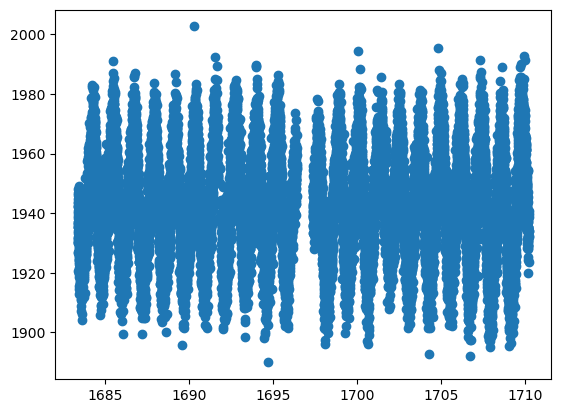

In [116]:
plt.scatter(masked_x, masked_y)
plt.show()

Initial log likelihood: -9327478.519887699


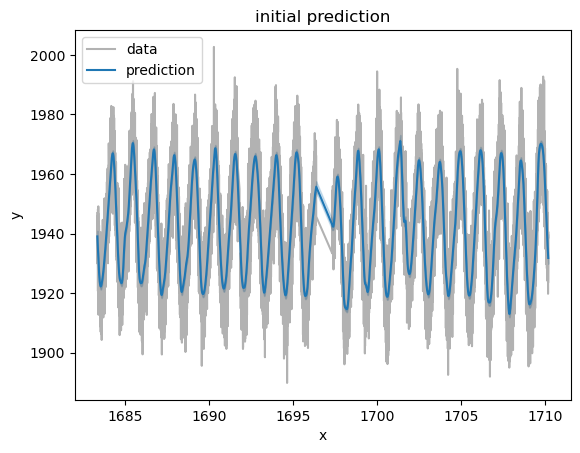

In [142]:
# Setup the GP
gp = celerite2.GaussianProcess(kernel, mean=0.0)
gp.compute(masked_x, yerr=masked_yerr)

print("Initial log likelihood: {0}".format(gp.log_likelihood(masked_y)))

def set_params(params, gp):
    gp.mean = params[0]
    theta = np.exp(params[1:])
    gp.kernel = terms.SHOTerm(
        sigma=theta[0], rho=theta[1], tau=theta[2]
    ) + terms.SHOTerm(sigma=theta[3], rho=theta[4], Q=0.25)
    gp.compute(masked_x, diag=masked_yerr**2 + theta[5], quiet=True)
    return gp


def neg_log_like(params, gp):
    gp = set_params(params, gp)
    return -gp.log_likelihood(masked_y)


initial_params = [0.0, 0.0, 0.0, np.log(10.0), 0.0, np.log(5.0), np.log(0.01)]
soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(gp,))
opt_gp = set_params(soln.x, gp)
soln

def plot_prediction(gp):
    plt.plot(masked_x, masked_y, "k", lw=1.5, alpha=0.3, label="data")
    #plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label="truth")

    if gp:
        mu, variance = gp.predict(y=np.array(masked_y), t=masked_x, return_var=True)
        sigma = np.sqrt(variance)
        plt.plot(masked_x, mu, label="prediction")
        plt.fill_between(masked_x, mu - sigma, mu + sigma, color="C0", alpha=0.2)

    plt.xlabel("x")
    plt.ylabel("y")
    #plt.xlim(0, 10)
    #plt.ylim(-2.5, 2.5)
    plt.legend()

plt.title("initial prediction")
plot_prediction(opt_gp)
#plt.ylim(2000, 2100)

plt.show()

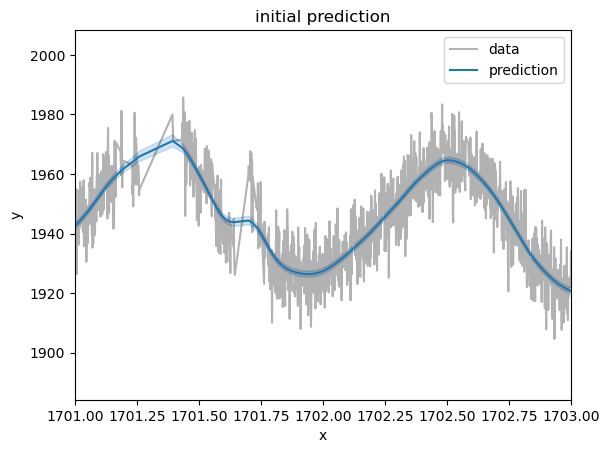

In [144]:
plt.title("initial prediction")
plot_prediction(opt_gp)
plt.xlim(1701, 1703)

plt.show()